In [2]:
using NextGenSeqUtils, PyPlot, StatsBase, CSV, DataFrames

#Collapse identical sequences.
function dedup(reads; thresh = 0)
    cm = countmap(reads)
    filt = values(cm) .>= thresh
    println("Keeping: ",sum(filt),". Discarding: ",sum(.!filt))
    pairs = sort(collect(zip(collect(values(cm))[filt],collect(keys(cm))[filt])),rev = true)
    return [p[2] for p in pairs],[p[1] for p in pairs]
end

function trimmed_hamming_dist(ref,seq)
    ls,lr = length(seq),length(ref)
    if ls < lr
        return Inf
    end
    return sum(collect(ref) .!= collect(seq[1:lr]))
end

function IUPAC_dist(s1,s2)
    return Int(round(NextGenSeqUtils.IUPAC_nuc_edit_dist(s1,s2)))
end

function match_tail(tail,refs,refnames)
    len = min(length(tail),length(refs[1])) #assumes same length refs
    if len > 5
        scores = [IUPAC_dist(r[1:len],tail[1:len]) for r in refs]
        pos = argmax(scores)
        if scores[pos]/len >= -0.2 #Play with this
            return join(refnames[scores .> scores[pos]-2],"_") #Play with the -2
        else
            return "NoMatch"
        end
    else
        return "NoMatch"
    end
    
end

#Checks matching isotype, and only 1 nuc difference.
function close_enough(taggedseq1::Tuple{String,String},taggedseq2::Tuple{String,String})
    if (taggedseq1[2] == taggedseq2[2]) && (length(taggedseq1[1]) == length(taggedseq2[1]))
        d = sum(collect(taggedseq1[1]) .!= collect(taggedseq2[1]))
        if d > 1
            return false
        else
            return true
        end
    else
        return false
    end
end

#Absorbs outliers into a whitelist if they're close enough.
function absorb(whitelist,whitelist_sizes,sketch,sketch_sizes,close_func)
    size_perm = sortperm(whitelist_sizes,rev = true)
    whitelist = whitelist[size_perm]
    whitelist_sizes = whitelist_sizes[size_perm]
    
    sketch_keep_inds = Int[]
    
    for i in 1:length(sketch)
        closey = [close_func(w,sketch[i]) for w in whitelist]
        maxey = argmax(closey)
        if closey[maxey]
            whitelist_sizes[maxey] += sketch_sizes[i]
        else
            push!(sketch_keep_inds,i)
        end
    end
    vcat(whitelist,sketch[sketch_keep_inds])
    return vcat(whitelist,sketch[sketch_keep_inds]),vcat(whitelist_sizes,sketch_sizes[sketch_keep_inds])
end

absorb (generic function with 1 method)

In [3]:
#Data in the form of VRC01_J_F6_PID_Alt2_RB_barcode_aware_dereplicated_threshX etc has been collapsed down
#to oestensibly transcript level. Now we discard the barcode, and collapse down to variant level.

#paired VRC01 reference without the primers. Note, this is specific to the primer trimming from earlier pipeline steps.
ref = uppercase("agaaattgtgttgacacagtctccaggcaccctgtctttgtctccaggggaaacagccatcatctcttgtcggaccagtcagtatggttccttagcctggtatcaacagaggcccggccaggcccccaggctcgtcatctattcgggctctactcgggccgctggcatcccagacaggttcagcggcagtcggtgggggccagactacaatctcaccatcagcaacctggagtcgggagattttggtgtttattattgccagcagtatgaattttttggccaggggaccaaggtccaggtcgacattaagcgacgggctgatgctgcaccaactgtatccatcttcccaccatccagtgagcagttaacatctggaggtgcctcagtcgtgtgcttcttgaacaacttctaccccaaagacatcaatgtcaagtggaagattgatggcagtgaacgacaaaatggcgtcctgaacagttggactgatcaggacagcaaagacagcacctacagcatgagcagcaccctcacgttgaccaaggacgagtatgaacgacataacagctatacctgtgaggccactcacaagacatcaacttcacccattgtcaagagcttcaacaggaatgagtgtggaagcggcgccactaatttcagtcttctgaaacaggccggagacgtggaggagaatcctggacccatggaatggccttgtatctttctcttcctcctgtcagtaactgaaggtgtccactcccaggtgcagctggtgcagtctgggggtcagatgaagaaaccgggcgagtccatgcgtatttcctgccgcgcatccggctatgaattcatcgactgtaccctgaattggatccgcctggccccagggaagcgccccgaatggatgggttggctgaagccaaggggcggcgcggtgaactatgccaggccgctgcagggacgtgtgacaatgactcgtgatgtctattctgacaccgcgttcctggagctgaggtctctcaccgtcgacgatacagcggtgtatttctgcactagaggcaaaaactgcgattacaactgggacttcgagcactggggccggggcaccc");
#Reference for iso seq can be longer.
isoref = uppercase("agaaattgtgttgacacagtctccaggcaccctgtctttgtctccaggggaaacagccatcatctcttgtcggaccagtcagtatggttccttagcctggtatcaacagaggcccggccaggcccccaggctcgtcatctattcgggctctactcgggccgctggcatcccagacaggttcagcggcagtcggtgggggccagactacaatctcaccatcagcaacctggagtcgggagattttggtgtttattattgccagcagtatgaattttttggccaggggaccaaggtccaggtcgacattaagcgacgggctgatgctgcaccaactgtatccatcttcccaccatccagtgagcagttaacatctggaggtgcctcagtcgtgtgcttcttgaacaacttctaccccaaagacatcaatgtcaagtggaagattgatggcagtgaacgacaaaatggcgtcctgaacagttggactgatcaggacagcaaagacagcacctacagcatgagcagcaccctcacgttgaccaaggacgagtatgaacgacataacagctatacctgtgaggccactcacaagacatcaacttcacccattgtcaagagcttcaacaggaatgagtgtggaagcggcgccactaatttcagtcttctgaaacaggccggagacgtggaggagaatcctggacccatggaatggccttgtatctttctcttcctcctgtcagtaactgaaggtgtccactcccaggtgcagctggtgcagtctgggggtcagatgaagaaaccgggcgagtccatgcgtatttcctgccgcgcatccggctatgaattcatcgactgtaccctgaattggatccgcctggccccagggaagcgccccgaatggatgggttggctgaagccaaggggcggcgcggtgaactatgccaggccgctgcagggacgtgtgacaatgactcgtgatgtctattctgacaccgcgttcctggagctgaggtctctcaccgtcgacgatacagcggtgtatttctgcactagaggcaaaaactgcgattacaactgggacttcgagcactggggccggggcaccccggtcatcgtctcatca")
RT_primer_ref = uppercase("cggtcatcgtctcatca");

In [5]:
dir = "IsotypeRT"
files = readdir(dir)

8-element Array{String,1}:
 "VRC01_J_F1_PID_Alt2_RA_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F1_PID_Alt2_RC_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F2_PID_Alt2_RA_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F2_PID_Alt2_RC_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F3_PID_Alt2_RB_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F4_PID_Alt2_RB_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F5_PID_Alt2_RA_barcode_aware_dereplicated_thresh2.fasta"
 "VRC01_J_F6_PID_Alt2_RA_barcode_aware_dereplicated_thresh2.fasta"

In [7]:
classnames = ["IgA",
"IgG3",
"IgG2A/C",
"IgG1",
"IgG2B",
"MISPRIME", #NOTE: This is the IgM primer using 6bp to prime off any of IgG3A/C, IgG1, or IgG2B. 
"IgM",
"IgE"]
classrefs = uppercase.([
"AGAGTCTGCGAGAAATCCCACCATCTA",
"AGCTACAACAACAGCCCCATCTGTCTA",
"AGCCAAAACAACAGCCCCATCGGTCTA",
"AGCCAAAACGACACCCCCATCTGTCTA",
"AGCCAAAACAACACCCCCATCAGTCTA",
"AGCCAAAACAACACTGAAGTCATCCAG", #MISPRIME: This is the IgM primer using 6bp to prime off any of IgG3A/C, IgG1, or IgG2B.
"AGAGAGTCAGTCCTTCCCAAATGTCTT",
"agcctctatcaggaaccctcagctcta"]);

In [10]:
CDRs = [283:287,303:318,351:362,24:32,48:54,87:91];

robust_translate(str) = translate_to_aa(str[1:Int(floor(end/3)*3)])
get_ranges(str,ranges) = [str[r] for r in ranges]
dot_string(ref,seq) = join([ifelse(ref[i]==seq[i],".",seq[i]) for i in 1:length(ref)])
codon_dot_string(ref,seq) = join([ifelse(ref[i:i+2]==seq[i:i+2],".",translate_to_aa(seq[i:i+2])) for i in 1:3:Int(floor(length(ref)/3)*3)])

ref_ranges = get_ranges(robust_translate(ref[2:end]),CDRs)


6-element Array{String,1}:
 "DCTLN"           
 "LKPRGGAVNYARPLQG"
 "GKNCDYNWDFEH"    
 "RTSQYGSLA"       
 "SGSTRAA"         
 "QQYEF"           

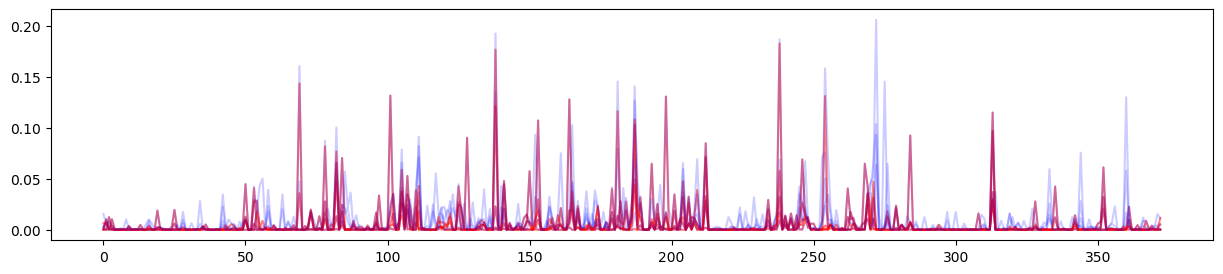

Running: F1_RA
Num reads: 13604
Alignment filter - keeping: 0.9786092325786533
Keeping: 1343. Discarding: 0
F1_RA included in plot
mean(nuc_muts) = 0.45384382454818734
Running: F1_RC
Num reads: 0
Running: F2_RA
Num reads: 16192
Alignment filter - keeping: 0.979681324110672
Keeping: 1473. Discarding: 0
F2_RA included in plot
mean(nuc_muts) = 0.38191453661746055
Running: F2_RC
Num reads: 9
Alignment filter - keeping: 0.2222222222222222
Keeping: 2. Discarding: 0
FAILED.
Running: F3_RB
Num reads: 10001
Alignment filter - keeping: 0.9482051794820517
Keeping: 675. Discarding: 0
F3_RB included in plot
mean(nuc_muts) = 0.2004647006255586
Running: F4_RB
Num reads: 11324
Alignment filter - keeping: 0.9756269869304133
Keeping: 962. Discarding: 0
F4_RB included in plot
mean(nuc_muts) = 0.2774121916213069
Running: F5_RA
Num reads: 2465
Alignment filter - keeping: 0.9687626774847871
Keeping: 275. Discarding: 0
F5_RA included in plot
mean(nuc_muts) = 0.4578993570428717
Running: F6_RA
Num reads: 53
Al

In [180]:
sample_names = []
total_template_counts = []
mut_vectors = []

fig = figure(figsize=(15, 3))

#Without absorb.
for ind in 1:length(files)
    try
        file = files[ind]
        prefix = file[9:10]*"_"*file[21:22]
        println("Running: ",prefix)
        seqs = read_fasta(dir*"/"*file);
        println("Num reads: ",length(seqs))
        if length(seqs) < 5
            continue;
        end
        ref_dists = trimmed_hamming_dist.(isoref,seqs)
        primer_dists = [trimmed_hamming_dist(RT_primer_ref,s[length(ref)+1:end]) for s in seqs];
        #plot(primer_dists,ref_dists,".")
        filt = (primer_dists .<= 2) .& (ref_dists .<= 150);
        println("Alignment filter - keeping: ",sum(filt)/length(filt))

        filt_seqs = seqs[filt];
        tails = [fs[length(ref)+17:end] for fs in filt_seqs]; #Number hax. Bad.
        isotypes = [match_tail(tail,classrefs,classnames) for tail in tails];

        write_fasta("IsotypeRT_noAbsorbing/IsoLogging/"*prefix*".isologging.fasta",tails,names = ["$(isotypes[i])_s$(i)" for i in 1:length(isotypes)])

        strt = 2 #Dropping the first base to start in frame.    
        templates = [(filt_seqs[i][strt:length(isoref)],isotypes[i]) for i in 1:length(filt_seqs)];
        variants,sizes = dedup(templates);

        #size_thresh_filt = sizes .> 1
        #variants,sizes = absorb(variants[size_thresh_filt],sizes[size_thresh_filt],variants[.!size_thresh_filt],sizes[.!size_thresh_filt],close_enough);

        variant_isos = [v[2] for v in variants]
        variants = [v[1] for v in variants]

        iso_filt = [iso in ["IgA","IgG3","IgG2A/C","IgG1","IgG2B","IgM","IgE"] for iso in variant_isos]
        variants = variants[iso_filt]
        sizes = sizes[iso_filt]
        variant_isos = variant_isos[iso_filt]
        
        dotted_variants = [dot_string(robust_translate(isoref[2:end]),robust_translate(v)) for v in variants];
        mutation_freq_mask = [sizes[i] .* (collect(dotted_variants[i]) .!= '.') for i in 1:length(dotted_variants)];
        summed_muts = sum(mutation_freq_mask) ./ sum(sizes)
        
        codon_dotted_variants = [codon_dot_string((isoref[2:end]),(v)) for v in variants];
        codon_mutation_freq_mask = [sizes[i] .* (collect(codon_dotted_variants[i]) .!= '.') for i in 1:length(codon_dotted_variants)];
        codon_summed_muts = sum(codon_mutation_freq_mask) ./ sum(sizes)
        
        push!(sample_names,prefix)
        push!(total_template_counts,sum(sizes))
        push!(mut_vectors,summed_muts)
        
        if sum(sizes) > 250
            println(prefix * " included in plot")
            plot(summed_muts, color = "red", alpha = 0.5)
            plot(codon_summed_muts, color = "blue", alpha = 0.2)
        end
#       translated_variants = [robust_translate(v)) for v in variants];

        export_names = ["$(prefix)_$(i)_$(variant_isos[i])_$(sizes[i])" for i in 1:length(sizes)]

        nuc_muts = 100 .* ([trimmed_hamming_dist(isoref[strt:end],s) for s in variants] ./ length(isoref[strt:end]));
        @show mean(nuc_muts)

        df = DataFrame()
        df.name = export_names
        df.copynum = sizes
        df.ID = [prefix for i in 1:length(sizes)]
        df.iso = variant_isos
        df.iso_and_ID = [prefix for i in 1:length(sizes)].*"_".*variant_isos
        df.SHM = Array{Float64}(nuc_muts)
        CDRs = [283:287,303:318,351:362,24:32,48:54,87:91];
        df.CDRL1 = [d[24:32] for d in dotted_variants]
        df.CDRL2 = [d[48:54] for d in dotted_variants]
        df.CDRL3 = [d[87:91] for d in dotted_variants]
        df.CDRH1 = [d[283:287] for d in dotted_variants]
        df.CDRH2 = [d[303:318] for d in dotted_variants]
        df.CDRH3 = [d[351:362] for d in dotted_variants]
        df.dotted_seq = dotted_variants
        CSV.write("IsotypeRT_noAbsorbing/"*prefix*".annots.tsv",df,delim = "\t")

        variants = vcat([isoref[2:end]],variants)
        export_names = vcat(["PAIRED_VRC01_TRIMMED_REF"],export_names)
        write_fasta("IsotypeRT_noAbsorbing/"*prefix*".variants.fasta",variants,names = export_names)
    catch
        println("FAILED.")
    end
end
savefig("mutations.pdf")

for i in 1:length(mut_vectors)
    prepend!(mut_vectors[i],total_template_counts[i])
end
str_ref = string.(collect(robust_translate(isoref[2:end])))
str_ref = vcat(["Counts"],str_ref)

df = DataFrame()
df.refseq = str_ref
for i in 1:length(sample_names)
    df[!,Symbol(sample_names[i])] = mut_vectors[i]
end
CSV.write("IsotypeRT_noAbsorbing/MutationCounts.csv",df,delim = "\t")

In [99]:
#With absorb, where singletons get absorbed into a larger neighbour - use for plotting compact trees.
for ind in 1:length(files)
    try
        file = files[ind]
        prefix = file[9:10]*"_"*file[21:22]
        println("Running: ",prefix)
        seqs = read_fasta(dir*"/"*file);
        println("Num reads: ",length(seqs))
        #if length(seqs) < 5
        #    continue;
        #end
        ref_dists = trimmed_hamming_dist.(ref,seqs)
        primer_dists = [trimmed_hamming_dist(RT_primer_ref,s[length(ref)+1:end]) for s in seqs];
        #plot(primer_dists,ref_dists,".")
        filt = (primer_dists .<= 2) .& (ref_dists .<= 200);
        println("Alignment filter - keeping: ",sum(filt)/length(filt))

        filt_seqs = seqs[filt];
        tails = [fs[length(ref)+17:end] for fs in filt_seqs]; #Number hax. Bad.
        isotypes = [match_tail(tail,classrefs,classnames) for tail in tails];

        write_fasta("IsotypeRT_processed/IsoLogging/"*prefix*".isologging.fasta",tails,names = ["$(isotypes[i])_s$(i)" for i in 1:length(isotypes)])

        strt = 2 #Dropping the first base to start in frame.    
        templates = [(filt_seqs[i][strt:length(ref)],isotypes[i]) for i in 1:length(filt_seqs)];
        variants,sizes = dedup(templates);

        size_thresh_filt = sizes .> 1
        variants,sizes = absorb(variants[size_thresh_filt],sizes[size_thresh_filt],variants[.!size_thresh_filt],sizes[.!size_thresh_filt],close_enough);

        variant_isos = [v[2] for v in variants]
        variants = [v[1] for v in variants]

        iso_filt = [iso in ["IgA","IgG3","IgG2A/C","IgG1","IgG2B","IgM","IgE"] for iso in variant_isos]
        variants = variants[iso_filt]
        sizes = sizes[iso_filt]
        variant_isos = variant_isos[iso_filt]
        
        dotted_variants = [dot_string(robust_translate(ref[2:end]),robust_translate(v)) for v in variants];

        export_names = ["$(prefix)_$(i)_$(variant_isos[i])_$(sizes[i])" for i in 1:length(sizes)]

        nuc_muts = 100 .* ([trimmed_hamming_dist(ref[strt:end],s) for s in variants] ./ length(ref[strt:end]));
        @show mean(nuc_muts)

        df = DataFrame()
        df.name = export_names
        df.copynum = sizes
        df.ID = [prefix for i in 1:length(sizes)]
        df.iso = variant_isos
        df.iso_and_ID = [prefix for i in 1:length(sizes)].*"_".*variant_isos
        df.SHM = Array{Float64}(nuc_muts)
        CDRs = [283:287,303:318,351:362,24:32,48:54,87:91];
        df.CDRL1 = [d[24:32] for d in dotted_variants]
        df.CDRL2 = [d[48:54] for d in dotted_variants]
        df.CDRL3 = [d[87:91] for d in dotted_variants]
        df.CDRH1 = [d[283:287] for d in dotted_variants]
        df.CDRH2 = [d[303:318] for d in dotted_variants]
        df.CDRH3 = [d[351:362] for d in dotted_variants]
        df.dotted_seq = dotted_variants
        CSV.write("IsotypeRT_processed/"*prefix*".annots.tsv",df,delim = "\t")

        variants = vcat([ref[2:end]],variants)
        export_names = vcat(["PAIRED_VRC01_TRIMMED_REF"],export_names)
        write_fasta("IsotypeRT_processed/"*prefix*".variants.fasta",variants,names = export_names)
    catch
        println("FAILED.")
    end
end

Running: F1_RA
Num reads: 13604
Alignment filter - keeping: 0.9786092325786533
Keeping: 1331. Discarding: 0
mean(nuc_muts) = 0.4666405226373854
Running: F1_RC
Num reads: 0
FAILED.
Running: F2_RA
Num reads: 16192
Alignment filter - keeping: 0.9797430830039525
Keeping: 1462. Discarding: 0
mean(nuc_muts) = 0.4698723709172496
Running: F2_RC
Num reads: 9
Alignment filter - keeping: 0.2222222222222222
Keeping: 2. Discarding: 0
FAILED.
Running: F3_RB
Num reads: 10001
Alignment filter - keeping: 0.9482051794820517
Keeping: 662. Discarding: 0
mean(nuc_muts) = 0.1982409604914142
Running: F4_RB
Num reads: 11324
Alignment filter - keeping: 0.9756269869304133
Keeping: 942. Discarding: 0
mean(nuc_muts) = 0.3256416904329789
Running: F5_RA
Num reads: 2465
Alignment filter - keeping: 0.9687626774847871
Keeping: 268. Discarding: 0
mean(nuc_muts) = 0.48452355184068985
Running: F6_RA
Num reads: 53
Alignment filter - keeping: 0.9811320754716981
Keeping: 26. Discarding: 0
mean(nuc_muts) = 0.7803992740471869